[View in Colaboratory](https://colab.research.google.com/github/aksh98/FintechProject/blob/master/NowCastingData_Regression.ipynb)

In [0]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

In [0]:
!pip install -U -q PyDrive


In [0]:
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
creds = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)




In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving GoogleTrendsData.csv to GoogleTrendsData.csv
User uploaded file "GoogleTrendsData.csv" with length 4934 bytes


In [7]:
!ls
!cd sample_data/

adc.json  datalab  GoogleTrendsData.csv  sample_data


In [12]:
%cd ..
!ls

/content
adc.json  datalab  GoogleTrendsData.csv  sample_data


In [54]:
datafile = pd.read_csv('GoogleTrendsData.csv')
datafile.shape

(176, 8)

In [55]:
# datafile.shape[0]
datafile.tail()

,Month,Employment,Unemployment,Productivity,GDP,Stock market,jobs,UMEX
171,2018-04,74,18,1,4,13,68,127.0
172,2018-05,71,16,1,4,9,68,134.0
173,2018-06,71,17,1,3,9,71,132.0
174,2018-07,71,18,1,5,9,71,NaN
175,2018-08,85,16,1,5,11,81,NaN


In [0]:
# print(datafile['UMEX'].max())
# print(datafile['UMEX'].min())

datafile.drop(datafile.tail(2).index,inplace=True)

In [57]:
datafile.tail()

,Month,Employment,Unemployment,Productivity,GDP,Stock market,jobs,UMEX
169,2018-02,72,20,1,5,27,63,136.0
170,2018-03,71,17,1,4,15,64,134.0
171,2018-04,74,18,1,4,13,68,127.0
172,2018-05,71,16,1,4,9,68,134.0
173,2018-06,71,17,1,3,9,71,132.0


In [0]:
Y = datafile['UMEX']
X = datafile[['Employment','Productivity','GDP','Stock market','jobs']]

In [59]:
X.head()
print(X.shape)

(174, 5)


In [60]:
Y.tail()
# Y.shape 

169    136.0
170    134.0
171    127.0
172    134.0
173    132.0
Name: UMEX, dtype: float64

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)

[-2.44601783 45.10748144 -1.2734437  -0.04736015  0.8963163 ]
180.63077577412534
tsne shape -  (174, 2)


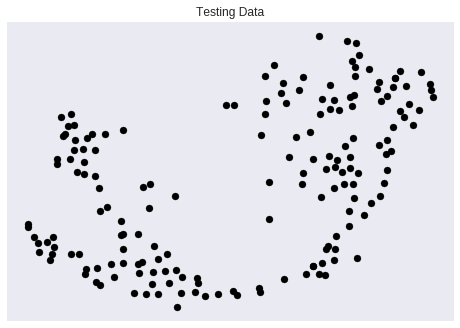

114.0  ->  112.77492586244972
110.0  ->  103.82662876130075
131.0  ->  99.34680105773307
79.0  ->  81.14682243604219
95.0  ->  115.8142420587046
77.0  ->  77.87730999139688
121.0  ->  90.01396659954979
84.0  ->  77.68172011879346
6.0  ->  84.94519809808054
73.0  ->  104.8181206105946
10.0  ->  74.6462954473291
108.0  ->  105.51228041238645
128.0  ->  75.1563031703081
121.0  ->  105.86396521071798
83.0  ->  47.374401603042344
111.0  ->  103.91521873711977
112.0  ->  108.54853608049812
7.0  ->  60.85862217226395
71.0  ->  76.2688201911167
98.0  ->  96.76528834474276
132.0  ->  111.46287656482937
134.0  ->  103.6310578283067
111.0  ->  115.06745405056724
111.0  ->  105.3447763012542
97.0  ->  97.58223527133418
88.0  ->  77.96412721052236
133.0  ->  98.22158708007069
95.0  ->  58.05478921888552
139.0  ->  94.21183431741375
56.0  ->  66.24179885533161
107.0  ->  81.67872724196906
136.0  ->  111.17786418718305
88.0  ->  77.81852171491452
114.0  ->  108.67920734950053
101.0  ->  98.2356204910

In [87]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

reg = LinearRegression()
reg.fit(X_train,Y_train)
print(reg.coef_)
print(reg.intercept_)

tsne = TSNE(n_components=2).fit_transform(X)
print("tsne shape - ",tsne.shape)

plt.scatter(tsne[:,0],tsne[:,1],color = 'black')
plt.title('Testing Data')
plt.xticks(())
plt.yticks(())
# plt.plot(Y_test,reg.predict(X_test),color = 'red',linewidth=3)
plt.show()

test = np.asarray(Y_test)
arr = reg.predict(X_test)
for i in range(0,len(Y_test)):
  print(test[i]," -> ",arr[i])

In [83]:
print(Y_test)

143    114.0
144    110.0
159    131.0
80      79.0
25      95.0
30      77.0
12     121.0
39      84.0
58       6.0
20      73.0
57      10.0
121    108.0
0      128.0
125    121.0
74      83.0
146    111.0
154    112.0
60       7.0
78      71.0
9       98.0
173    132.0
170    134.0
150    111.0
127    111.0
96      97.0
38      88.0
134    133.0
75      95.0
133    139.0
69      56.0
3      107.0
131    136.0
79      88.0
149    114.0
108    101.0
Name: UMEX, dtype: float64
